# Discovering the Poisson Equation with SR-DEC

In this tutorial, we are going to see how to discover the **1D Poisson equation** using `flex` and **SR-DEC**, a new symbolic regression strategy developed in the paper [Discovering interpretable physical models using symbolic regression and discrete exterior calculus
](https://iopscience.iop.org/article/10.1088/2632-2153/ad1af2/meta). 
The 1D Poisson equation is a second-order elliptic partial differential equation that models steady-state diffusion processes such as heat conduction, electrostatics, and gravitational potential in one spatial dimension. It is typically written as  
$$\frac{d^2 u(x)}{dx^2} + f(x) = 0, \quad x \in (a,b),$$
where $u(x)$is the unknown scalar field and $f(x)$ is a given source term. To obtain a unique solution, the equation must be complemented with appropriate boundary conditions, such as Dirichlet conditions at $x=a$ and $x=b$. 
The 1D Poisson equation admits a natural **variational (weak) formulation**, that is, under mild assumptions on $f$, finding the solution of the Poisson equation is equivalent on minimizing the Dirichlet functional
$$\mathcal{F}(u) := \frac{1}{2}\int_a^b (u'(x))^2\,dx - \int_a^b f(x)\,u(x)\,dx$$
under some Dirichlet boundary conditions.
The mathematical language used to discretize the variational and non-variational formulation of the Poisson equation is **Discrete Exterior Calculus**. The (discrete) Poisson equation is then written as
$$\delta d u + f = 0 \quad \text{or equivalently} \quad \star d \star d u + f = 0,$$
and its variational formulation becomes
$$\mathcal{F}(u) := \frac{1}{2}\langle du, du \rangle - \langle u, f \rangle = \frac{1}{2}\langle \delta du, u \rangle - \langle u, f \rangle.$$

For the non-variational formulation, the SR strategy discovers the LHS of the equation, while in the variational case the goal is finding the Dirichlet functional. The DEC language is handled by [`dctkit`](https://github.com/cpml-au/dctkit). 

## Imports and dependencies

Main components:
- `dctkit`: used for mesh generation, cochains, and discrete differential operators.
- `ray`: enables parallel execution of genetic programming runs.
- `numpy`: numerical array handling.

In [ ]:
!export RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0

In [3]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_line_mesh, build_complex_from_mesh
from dctkit.math.opt import optctrl as oc
from deap import gp
from flex.gp import regressor as gps
from flex.gp.util import compile_individuals
from dctkit import config
import dctkit
import numpy as np
import jax.numpy as jnp
import ray
import math
from typing import Tuple, Callable, List
import os
from flex.gp.util import load_config_data
from flex.gp.primitives import add_primitives_to_pset_from_dict

import matplotlib.pyplot as plt

In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
os.environ["JAX_PLATFORMS"] = "cpu"
config()

## Evaluation metric

Let $\Omega$ be the domain where the Poisson equation is defined. To evaluate each individual, we numerically compute the solution by solving the following optimization problem

$$\min_{v \in \mathbb{R}^n} F_I(v, f)|_{\Omega} + \gamma ||v|_{\partial\Omega} - u|_{\partial\Omega}||^2,$$

where $F_I(v, f) := ||I(v,f)|_{\Omega}||^2$ for the non-variational case, otherwise $F_I(v, f) := I(v,f)$. Let $u_I$ be the solution of the optimization problem, then the evaluation metric used is the standard MSE between $u_I$ and the data $u$.

In [35]:
def eval_MSE_sol(
    individual: Callable, X, y, S: SimplicialComplex, u_0: C.CochainP0, residual_mode: bool ="True"
) -> float:

    num_nodes = S.num_nodes

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    os.environ["JAX_PLATFORMS"] = "cpu"
    config()

    if residual_mode:

        # objective: squared norm of the residual of the equation + penalty on Dirichlet
        # boundary condition on the first node
        def obj(x, y):
            penalty = 100./2 * (x[0] ** 2 + (x[-1]-1)**2)
            u = C.CochainP0(S, x)
            f = C.CochainP0(S, y)
            r = individual(u, f).coeffs.flatten()[1:-1]
            total_energy = jnp.linalg.norm(r)**2 + penalty
            return total_energy
    else:
        # objective: variational formulation of the equation + penalty on Dirichlet
        # boundary condition on the first node
        def obj(x, y):
            penalty = 100./2 * (x[0] ** 2 + (x[-1]-1)**2)
            u = C.CochainP0(S, x)
            f = C.CochainP0(S, y)
            total_energy = individual(u, f) + penalty
            return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    MSE = 0.0

    # set additional arguments of the objective function
    # (apart from the vector of unknowns)
    args = {"y": X}
    prb.set_obj_args(args)

    # minimize the objective
    u = prb.solve(x0=u_0.coeffs.flatten(), ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

    if y is not None:
        if (
            prb.last_opt_result == 1
            or prb.last_opt_result == 3
            or prb.last_opt_result == 4
        ):
            MSE = np.mean(np.linalg.norm(u - y) ** 2)
        else:
            MSE = math.nan

        if math.isnan(MSE):
            MSE = 1e5

    return MSE, [u]

## Fitness, predict and score functions

In [28]:
def get_features_batch(individ_feature_extractors, individuals_str_batch):
    features_batch = [
        [fe(i) for i in individuals_str_batch] for fe in individ_feature_extractors
    ]

    indlen = features_batch[0]
    return indlen

def fitness(
    individuals_str: list[str],
    toolbox,
    X,
    y,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    residual_mode: bool,
    penalty: dict,
) -> Tuple[float,]:

    callables = compile_individuals(toolbox, individuals_str)
    indlen = get_features_batch([len], individuals_str)

    fitnesses = [None] * len(individuals_str)
    for i, ind in enumerate(callables):
        MSE, _ = eval_MSE_sol(ind, X, y, S, u_0, residual_mode)

        # add penalty on length of the tree to promote simpler solutions
        fitnesses[i] = (MSE + penalty["reg_param"] * indlen[i],)

    return fitnesses


def predict(
    individuals_str: list[str],
    toolbox,
    X,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    residual_mode: bool,
    penalty: dict,
) -> List:

    callables = compile_individuals(toolbox, individuals_str)

    u = [None] * len(individuals_str)

    for i, ind in enumerate(callables):
        _, u[i] = eval_MSE_sol(ind, X, None, S, u_0, residual_mode)

    return u


def score(
    individuals_str: list[str],
    toolbox,
    X,
    y,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    residual_mode: bool,
    penalty: dict,
) -> List:

    callables = compile_individuals(toolbox, individuals_str)

    MSE = [None] * len(individuals_str)

    for i, ind in enumerate(callables):
        MSE[i], _ = eval_MSE_sol(ind, X, y, S, u_0, residual_mode)

    return MSE

## Training Pipeline

We consider a **1D spatial domain** discretized using a simplicial complex. 
The mesh is generated as a line mesh and then converted into a `SimplicialComplex` object, which is required by the DEC framework.

To validate the symbolic regression pipeline, we generate data from an exact solution, that is:
$$u(x) := x^2.$$
This function is sampled on the mesh vertices and stored as a primal 0-cochain.
Using a known analytical solution allows us to:
- compute the exact forcing term,
- assess whether the learned symbolic model recovers the correct operator.

In [33]:
filename = "sr_dec.yaml"
residual_mode = True

regressor_params, config_file_data = load_config_data(filename)

# generate mesh and dataset
mesh, _ = generate_line_mesh(num_nodes=11, L=1.0)
S = build_complex_from_mesh(mesh)
S.get_hodge_star()
x = S.node_coords
num_nodes = S.num_nodes

# generate training and test datasets
# exact solution = x²
u = C.CochainP0(S, np.array(x[:, 0] ** 2, dtype=dctkit.float_dtype))
# compute source term such that u solves the discrete Poisson equation
# Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
f = C.laplacian(u)
f.coeffs *= -1.0

X_train = np.array(f.coeffs.ravel(), dtype=dctkit.float_dtype)
y_train = np.array(u.coeffs.ravel(), dtype=dctkit.float_dtype)

# initial guess for the unknown of the Poisson problem (cochain of nodals values)
u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
u_0 = C.CochainP0(S, u_0_vec)

# define primitive set for the residual of the discrete Poisson equation
if residual_mode:
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)
else:
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], float)

# rename arguments of the residual
pset.renameArguments(ARG0="u")
pset.renameArguments(ARG1="f")

pset = add_primitives_to_pset_from_dict(pset, config_file_data["gp"]["primitives"])

penalty = config_file_data["gp"]["penalty"]
common_params = {"S": S, "u_0": u_0, "penalty": penalty, "residual_mode": residual_mode}

gpsr = gps.GPSymbolicRegressor(
    pset_config=pset,
    fitness=fitness,
    score_func=score,
    predict_func=predict,
    print_log=True,
    common_data=common_params,
    seed_str=None,
    save_best_individual=True,
    save_train_fit_history=True,
    output_path="./",
    remove_init_duplicates=True,
    **regressor_params
)

gpsr.fit(X_train, y_train, X_val=X_train, y_val=y_train)

u_best = gpsr.predict(X_train)

fit_score = gpsr.score(X_train, y_train)

gpsr.save_best_test_sols(X_train, "./")

ray.shutdown()

2026-01-19 10:05:29,642	INFO worker.py:2007 -- Started a local Ray instance.


Generating initial population(s)...
 Removing duplicates from initial population(s)...
 DONE.
DONE.
Evaluating initial population(s)...
DONE.
 -= START OF EVOLUTION =- 


(pid=gcs_server) [2026-01-19 10:05:57,228 E 9944 9944] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


   	     	           fitness            	             size             
   	     	------------------------------	------------------------------
gen	evals	min   	avg   	max   	std   	min	avg  	max	std   
1  	20   	0.7063	1.6565	2.2333	0.3679	3  	10.15	13 	3.4825
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), AddCP0(f, u))


(raylet) [2026-01-19 10:05:59,690 E 10060 10060] (raylet) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


2  	20   	0.7063	1.3641	1.6004	0.2995	7  	11.8 	15 	2.1354
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), AddCP0(f, u))
3  	20   	0.7063	1.1766	1.6004	0.2893	7  	10.8 	15 	2.5219
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), AddCP0(f, u))


(fitness pid=10127) [2026-01-19 10:06:04,644 E 10127 10262] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


4  	20   	0.5   	0.9531	1.3   	0.2002	5  	8.8  	13 	1.99  
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)


[2026-01-19 10:06:05,317 E 2190 10123] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


5  	20   	0.5   	0.8462	1.0333	0.1528	5  	7.9  	9  	1.3379
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)
6  	20   	0.5   	0.7847	0.9063	0.162 	5  	7.8  	9  	1.6   
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)
7  	20   	0.5   	0.6632	0.9063	0.1648	5  	6.6  	9  	1.6248
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)
8  	20   	0.5   	0.5616	0.7063	0.0941	5  	5.6  	7  	0.9165
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)
9  	20   	0.5   	0.5   	0.5   	0     	5  	5    	5  	0     
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)
10 	20   	0.5   	0.5   	0.5   	0     	5  	5    	5  	0     
Best individuals of this generation:
AddCP0(delP1(cobP0(u)), f)
 -= END OF EVOLUTION =- 
The best individual is AddCP0(delP1(cobP0(u)), f)
The best fitness on the training set is 0.5
String of the best individual saved to disk.
Training fitness history saved to disk.
Best individual solution evaluated over the test set saved

(fitness pid=10137) [2026-01-19 10:06:05,224 E 10137 10941] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


## Plots

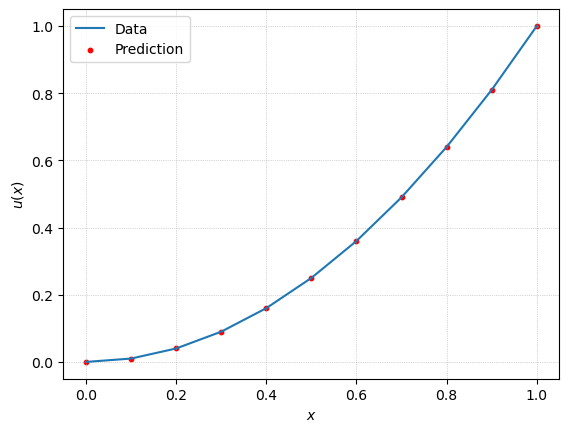

In [34]:
plt.plot(x[:,0], y_train, label="Data")
plt.scatter(x[:,0], u_best, c="r", s=10, label="Prediction")
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend()
plt.show()